In [1]:
%%capture
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from tqdm import tqdm 
from tensorboardX import SummaryWriter

# Data Loading

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# train_transform = A.Compose([
#     A.PadIfNeeded(min_height=512, min_width=512, border_mode=0),
#     A.RandomCrop(512, 512),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.ElasticTransform(p=0.2),
#     A.GridDistortion(p=0.2),
#     A.Normalize(mean=(0.5,), std=(0.5,)),  # Adjust if using RGB
#     ToTensorV2()
# ])

train_transform = A.Compose([
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0, mask_value=0),
    A.RandomCrop(256, 256, p= 0.5),
	A.RandomResizedCrop(scale=(0.75, 1),
						ratio=(0.95, 1.05),
						size=(256, 256)), 
	A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
	A.GaussNoise(std_range=(0.02, 0.1), p=0.6),
	
	A.RandomBrightnessContrast(brightness_limit=(-0.01, 0.01), contrast_limit=(-0.01, 0.01), p=0.5),
    A.ElasticTransform(alpha = 10, sigma = 250, p=0.5),
    A.GridDistortion(distort_limit=(-0.3,0.3), p=0.5),
    # #A.CLAHE(clip_limit=.5, tile_grid_size=(8, 8), p=0.5),
	A.ShiftScaleRotate(shift_limit=(-0.005,0.005), scale_limit=(-0.2, 0.005), rotate_limit=(-30,30), border_mode=0, value=0, p=0.9), 
    A.Downscale(scale_range=(0.85,0.99), p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
	ToTensorV2()
])

val_transform = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=0),
    A.CenterCrop(512, 512),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

c:\Users\mdiqb\anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mdiqb\anaconda3\envs\py312\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
C:\Users\mdiqb\AppData\Local\Temp\ipykernel_41180\2319099492.py:16: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0, mask_value=0),
c:\Users\mdiqb\anaconda3\envs\py312\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Pleas

In [3]:
from scipy.ndimage import distance_transform_edt
def compute_sdf(mask):
    pos = mask.astype(bool)
    neg = ~pos
    dist_out = distance_transform_edt(neg)
    dist_in = distance_transform_edt(pos)
    sdf = dist_out - dist_in
    return sdf

In [4]:
from PIL import Image
import os
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, test_mode=False):
        self.img_dir = img_dir
        self.mask_dir = img_dir.replace("images", "masks")
        self.transform = transform
        self.test_mode = test_mode

        self.imgs = [f for f in os.listdir(img_dir) if f.endswith(".JPG")]
        self.imgs.sort()

        if not test_mode:
            self.masks = [f.replace('.JPG', '.PNG') for f in self.imgs]
            self.masks.sort()

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img = np.array(Image.open(img_path).convert('L'))  # Grayscale

        if self.test_mode:
            if self.transform:
                transformed = self.transform(image=img)
                return transformed["image"]
            return torch.tensor(img).unsqueeze(0).float() / 255.

        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = np.array(Image.open(mask_path).convert('L'))
        mask = (mask > 0).astype('float32')  # Ensure binary

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img_aug = transformed["image"]
            mask_aug = transformed["mask"]

            sdf_aug = compute_sdf(mask_aug.numpy())
            sdf_aug = np.clip(sdf_aug, -128, 128) / 128.0

            return img_aug, torch.tensor(sdf_aug).unsqueeze(0).float()

        return torch.tensor(img).unsqueeze(0).float(), torch.tensor(mask).unsqueeze(0).float()

In [5]:
root_dir = "../../data"

In [6]:
train_dataset = CustomImageDataset(
    img_dir=os.path.join(root_dir, "OTU_2d", "images"),
    transform=train_transform,
    test_mode=False
)

test_dataset = CustomImageDataset(
    img_dir=os.path.join(root_dir, "OTU_2d", "images"),
    transform=val_transform,
    test_mode=True
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Assuming train_dataset is your instance of CustomImageDataset
total_train_samples = len(train_dataset)
train_size = int(0.8 * total_train_samples)  # 80% for training
validation_size = total_train_samples - train_size  # 20% for validation

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Now create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Feature batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape: torch.Size([8, 1, 256, 256])


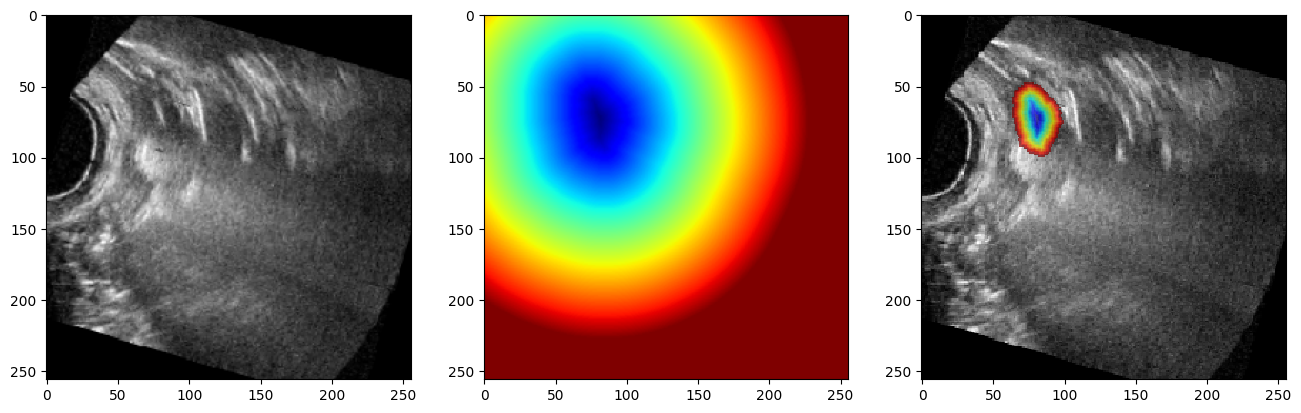

In [8]:
train_features, train_masks = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Masks batch shape: {train_masks.size()}")

img = train_features[0].squeeze()
mask = train_masks[0].squeeze()
img_mask = np.ma.masked_where(mask > 0, mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))

ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(mask, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
ax[2].imshow(img_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

# EDA

In [9]:
#takes long

def analyze_masks(dataloader):
    mask_presence = []

    for _, masks in dataloader:
        for mask in masks:
            # Assuming binary mask [0, 1]
            object_present = np.any(mask.numpy() > 0)
            mask_presence.append(object_present)

    return mask_presence

mask_presence_train = analyze_masks(train_dataloader)
mask_presence_validation = analyze_masks(validation_dataloader)

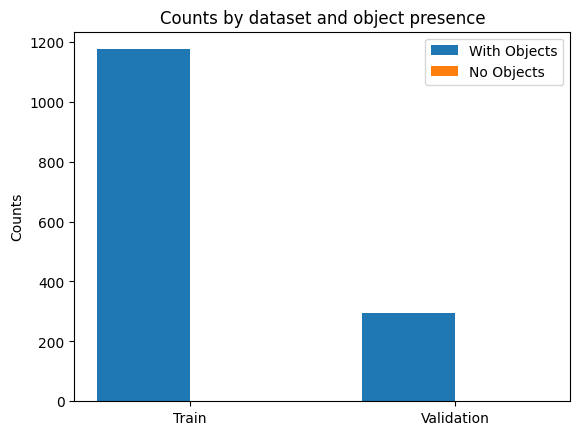

In [10]:
def plot_mask_presence(mask_presence_train, mask_presence_validation):
    train_objects = sum(mask_presence_train)
    train_no_objects = len(mask_presence_train) - train_objects
    validation_objects = sum(mask_presence_validation)
    validation_no_objects = len(mask_presence_validation) - validation_objects

    labels = ['Train', 'Validation']
    objects_counts = [train_objects, validation_objects]
    no_objects_counts = [train_no_objects, validation_no_objects]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, objects_counts, width, label='With Objects')
    rects2 = ax.bar(x + width/2, no_objects_counts, width, label='No Objects')

    ax.set_ylabel('Counts')
    ax.set_title('Counts by dataset and object presence')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_mask_presence(mask_presence_train, mask_presence_validation)

# Data Preprocessing

# Modeling

In [11]:
# %%capture
# !pip install -U segmentation-models-pytorch
# !pip install tqdm

In [12]:
import torch.nn as nn
import segmentation_models_pytorch as smp

class SDFModel(nn.Module):
    def __init__(self):
        super(SDFModel, self).__init__()
        self.backbone = smp.DeepLabV3Plus(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=1,
            classes=1
        )
        # self.backbone = smp.UnetPlusPlus(
        #     encoder_name="efficientnet-b1",   # or resnet34 for speed
        #     encoder_weights="imagenet",
        #     in_channels=1,
        #     classes=1,
        # )
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.backbone(x)        # Output shape: (B, 1, H, W)
        x = self.activation(x)      # Output in [-1, 1]
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SDFModel()
# Move your model to the GPU
model.to(device)

Using device: cuda


SDFModel(
  (backbone): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (

In [14]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [15]:
import torch 

def SDF_Dice_Loss(inputs, targets, smooth=1):
    # No sigmoid! Inputs are raw SDF predictions.
    inputs = inputs.contiguous().view(-1)
    targets = targets.contiguous().view(-1)

    intersection = (inputs * targets).sum()
    dice_score = (2. * intersection + smooth) / (inputs.pow(2).sum() + targets.pow(2).sum() + smooth)

    return 1 - dice_score


def L1_loss(inputs, targets):
    return torch.mean(torch.abs(inputs - targets))


def weighted_L1_loss(pred, target, alpha=2.0):
    weights = torch.exp(-alpha * torch.abs(target))  # Emphasize values near 0
    return (weights * torch.abs(pred - target)).mean()


def Zero_Level_Boundary_Loss(inputs, targets, threshold=0.3):
    # Zero-level masks
    pred_boundary = (torch.abs(inputs) < threshold).float()
    target_boundary = (torch.abs(targets) < threshold).float()

    intersection = (pred_boundary * target_boundary).sum()
    union = pred_boundary.sum() + target_boundary.sum()

    return 1 - (2. * intersection + 1e-5) / (union + 1e-5)

In [ ]:
#loss_function = combined_loss
λ1 = 1.0
λ2 = 0.5
λ3 = 0.2

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('../../runs/trainer_{}'.format(timestamp))
epoch_number = 0
EPOCHS = 100
best_vloss = 1_000_000.

# Define the training function
# Define the training function
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0

    # Iterate over the training dataset
    for i, data in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_index + 1}")):
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)  # Ensure labels are properly formatted

        optimizer.zero_grad()
        #outputs = model(inputs)
        pred_sdf = model(inputs)
        target_sdf = labels.float()  # Assuming labels are in the correct format for S
        #loss_value = combined_loss(outputs, labels)
        loss_value = (
                        λ1 * weighted_L1_loss(pred_sdf, target_sdf)
                        + λ2 * SDF_Dice_Loss(pred_sdf, target_sdf)
                        + λ3 * Zero_Level_Boundary_Loss(pred_sdf, target_sdf)
                    )
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()
        if i % 100 == 99:
            last_loss = running_loss / 100  # Average loss per batch
            print('  Batch {} Loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [20]:
# Main training and validation loop
EPOCHS = 100
for epoch in range(51,EPOCHS):
    
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train()
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.float().to(device)  # Shape: [batch_size, channels, height, width]
            vlabels = vlabels.float().to(device)

            voutputs = model(vinputs)
            #vloss = loss_function(voutputs, vlabels)  # Use the combined loss function
            vloss = (
                        λ1 * weighted_L1_loss(voutputs, vlabels.float())
                        + λ2 * SDF_Dice_Loss(voutputs, vlabels.float())
                        + λ3 * Zero_Level_Boundary_Loss(voutputs, vlabels.float())
                    )
            running_vloss += vloss.item()

    avg_vloss = running_vloss / len(validation_dataloader)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../../checkpoints/deeplabv3_sdf_randomcrop/model_{}/epoch_{}'.format(timestamp, epoch_number)
        base_path = '../../checkpoints/deeplabv3_sdf_randomcrop/model_{}'.format(timestamp)
        if not os.path.exists(base_path):
            os.makedirs(base_path)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 51:


Epoch 51:  68%|██████▊   | 100/147 [00:18<00:09,  4.91it/s]

  Batch 100 Loss: 0.13686015017330647


Epoch 51: 100%|██████████| 147/147 [00:28<00:00,  5.19it/s]


LOSS train 0.13686015017330647 valid 0.14181290234665614
EPOCH 52:


Epoch 52:  69%|██████▊   | 101/147 [00:20<00:07,  5.81it/s]

  Batch 100 Loss: 0.1484236080572009


Epoch 52: 100%|██████████| 147/147 [00:29<00:00,  5.03it/s]


LOSS train 0.1484236080572009 valid 0.11843203783438012
EPOCH 53:


Epoch 53:  68%|██████▊   | 100/147 [00:19<00:08,  5.24it/s]

  Batch 100 Loss: 0.13680134750902653


Epoch 53: 100%|██████████| 147/147 [00:28<00:00,  5.10it/s]


LOSS train 0.13680134750902653 valid 0.11796353455330874
EPOCH 54:


Epoch 54:  69%|██████▊   | 101/147 [00:15<00:07,  6.55it/s]

  Batch 100 Loss: 0.13060601998120547


Epoch 54: 100%|██████████| 147/147 [00:21<00:00,  6.69it/s]


LOSS train 0.13060601998120547 valid 0.1310687528268711
EPOCH 55:


Epoch 55:  69%|██████▊   | 101/147 [00:19<00:06,  7.15it/s]

  Batch 100 Loss: 0.1534457529336214


Epoch 55: 100%|██████████| 147/147 [00:27<00:00,  5.28it/s]


LOSS train 0.1534457529336214 valid 0.15668400236078212
EPOCH 56:


Epoch 56:  69%|██████▊   | 101/147 [00:19<00:08,  5.29it/s]

  Batch 100 Loss: 0.14242782741785048


Epoch 56: 100%|██████████| 147/147 [00:28<00:00,  5.10it/s]


LOSS train 0.14242782741785048 valid 0.1356713177787291
EPOCH 57:


Epoch 57:  69%|██████▊   | 101/147 [00:19<00:07,  5.81it/s]

  Batch 100 Loss: 0.13116352375596763


Epoch 57: 100%|██████████| 147/147 [00:28<00:00,  5.09it/s]


LOSS train 0.13116352375596763 valid 0.13805751552855647
EPOCH 58:


Epoch 58:  68%|██████▊   | 100/147 [00:18<00:09,  5.16it/s]

  Batch 100 Loss: 0.13175818737596273


Epoch 58: 100%|██████████| 147/147 [00:27<00:00,  5.28it/s]


LOSS train 0.13175818737596273 valid 0.12848933886837316
EPOCH 59:


Epoch 59:  69%|██████▊   | 101/147 [00:19<00:09,  5.02it/s]

  Batch 100 Loss: 0.1316682831197977


Epoch 59: 100%|██████████| 147/147 [00:28<00:00,  5.08it/s]


LOSS train 0.1316682831197977 valid 0.1276783142742273
EPOCH 60:


Epoch 60:  69%|██████▊   | 101/147 [00:19<00:08,  5.33it/s]

  Batch 100 Loss: 0.1324959411099553


Epoch 60: 100%|██████████| 147/147 [00:29<00:00,  5.05it/s]


LOSS train 0.1324959411099553 valid 0.12646116578095667
EPOCH 61:


Epoch 61:  68%|██████▊   | 100/147 [00:19<00:10,  4.66it/s]

  Batch 100 Loss: 0.12865210242569447


Epoch 61: 100%|██████████| 147/147 [00:29<00:00,  5.04it/s]


LOSS train 0.12865210242569447 valid 0.11722171427430333
EPOCH 62:


Epoch 62:  69%|██████▊   | 101/147 [00:19<00:09,  4.86it/s]

  Batch 100 Loss: 0.12940056931227445


Epoch 62: 100%|██████████| 147/147 [00:29<00:00,  5.05it/s]


LOSS train 0.12940056931227445 valid 0.13505358510726206
EPOCH 63:


Epoch 63:  69%|██████▊   | 101/147 [00:19<00:09,  4.84it/s]

  Batch 100 Loss: 0.13806661382317542


Epoch 63: 100%|██████████| 147/147 [00:27<00:00,  5.35it/s]


LOSS train 0.13806661382317542 valid 0.12109953185191026
EPOCH 64:


Epoch 64:  69%|██████▊   | 101/147 [00:15<00:06,  6.58it/s]

  Batch 100 Loss: 0.1332254648581147


Epoch 64: 100%|██████████| 147/147 [00:22<00:00,  6.67it/s]


LOSS train 0.1332254648581147 valid 0.12639987680154877
EPOCH 65:


Epoch 65:  69%|██████▊   | 101/147 [00:19<00:08,  5.56it/s]

  Batch 100 Loss: 0.12921291314065456


Epoch 65: 100%|██████████| 147/147 [00:28<00:00,  5.21it/s]


LOSS train 0.12921291314065456 valid 0.1372694898698781
EPOCH 66:


Epoch 66:  69%|██████▊   | 101/147 [00:18<00:09,  4.99it/s]

  Batch 100 Loss: 0.12370916429907083


Epoch 66: 100%|██████████| 147/147 [00:27<00:00,  5.26it/s]


LOSS train 0.12370916429907083 valid 0.1362322821609072
EPOCH 67:


Epoch 67:  68%|██████▊   | 100/147 [00:19<00:09,  4.93it/s]

  Batch 100 Loss: 0.1438278303295374


Epoch 67: 100%|██████████| 147/147 [00:28<00:00,  5.20it/s]


LOSS train 0.1438278303295374 valid 0.11726243169726552
EPOCH 68:


Epoch 68:  68%|██████▊   | 100/147 [00:19<00:10,  4.60it/s]

  Batch 100 Loss: 0.11934356696903706


Epoch 68: 100%|██████████| 147/147 [00:28<00:00,  5.22it/s]


LOSS train 0.11934356696903706 valid 0.11857396948176462
EPOCH 69:


Epoch 69:  69%|██████▊   | 101/147 [00:19<00:09,  4.79it/s]

  Batch 100 Loss: 0.12590059354901315


Epoch 69: 100%|██████████| 147/147 [00:28<00:00,  5.09it/s]


LOSS train 0.12590059354901315 valid 0.11151294802894464
EPOCH 70:


Epoch 70:  69%|██████▊   | 101/147 [00:18<00:08,  5.13it/s]

  Batch 100 Loss: 0.11582620158791541


Epoch 70: 100%|██████████| 147/147 [00:27<00:00,  5.39it/s]


LOSS train 0.11582620158791541 valid 0.13339504408272537
EPOCH 71:


Epoch 71:  68%|██████▊   | 100/147 [00:19<00:08,  5.62it/s]

  Batch 100 Loss: 0.13084713861346245


Epoch 71: 100%|██████████| 147/147 [00:28<00:00,  5.11it/s]


LOSS train 0.13084713861346245 valid 0.13716073414763888
EPOCH 72:


Epoch 72:  68%|██████▊   | 100/147 [00:19<00:09,  5.04it/s]

  Batch 100 Loss: 0.13590821985155344


Epoch 72: 100%|██████████| 147/147 [00:28<00:00,  5.08it/s]


LOSS train 0.13590821985155344 valid 0.11709682734028713
EPOCH 73:


Epoch 73:  68%|██████▊   | 100/147 [00:19<00:08,  5.41it/s]

  Batch 100 Loss: 0.13428128004074097


Epoch 73: 100%|██████████| 147/147 [00:29<00:00,  5.00it/s]


LOSS train 0.13428128004074097 valid 0.14210158687185598
EPOCH 74:


Epoch 74:  68%|██████▊   | 100/147 [00:19<00:09,  4.88it/s]

  Batch 100 Loss: 0.1219409465789795


Epoch 74: 100%|██████████| 147/147 [00:27<00:00,  5.28it/s]


LOSS train 0.1219409465789795 valid 0.12866327549154694
EPOCH 75:


Epoch 75:  69%|██████▊   | 101/147 [00:19<00:09,  4.77it/s]

  Batch 100 Loss: 0.12878295205533505


Epoch 75: 100%|██████████| 147/147 [00:28<00:00,  5.09it/s]


LOSS train 0.12878295205533505 valid 0.12295155987344883
EPOCH 76:


Epoch 76:  69%|██████▊   | 101/147 [00:19<00:09,  4.88it/s]

  Batch 100 Loss: 0.12030440121889115


Epoch 76: 100%|██████████| 147/147 [00:28<00:00,  5.14it/s]


LOSS train 0.12030440121889115 valid 0.12817693521847595
EPOCH 77:


Epoch 77:  69%|██████▊   | 101/147 [00:18<00:07,  6.46it/s]

  Batch 100 Loss: 0.11790258049964905


Epoch 77: 100%|██████████| 147/147 [00:26<00:00,  5.65it/s]


LOSS train 0.11790258049964905 valid 0.14238974663454132
EPOCH 78:


Epoch 78:  69%|██████▊   | 101/147 [00:16<00:08,  5.34it/s]

  Batch 100 Loss: 0.13467829417437316


Epoch 78: 100%|██████████| 147/147 [00:25<00:00,  5.76it/s]


LOSS train 0.13467829417437316 valid 0.14447596206052885
EPOCH 79:


Epoch 79:  69%|██████▊   | 101/147 [00:18<00:09,  4.97it/s]

  Batch 100 Loss: 0.1128953992575407


Epoch 79: 100%|██████████| 147/147 [00:26<00:00,  5.51it/s]


LOSS train 0.1128953992575407 valid 0.13346325153031866
EPOCH 80:


Epoch 80:  69%|██████▊   | 101/147 [00:18<00:06,  6.89it/s]

  Batch 100 Loss: 0.12381299044936896


Epoch 80: 100%|██████████| 147/147 [00:27<00:00,  5.35it/s]


LOSS train 0.12381299044936896 valid 0.134856832389896
EPOCH 81:


Epoch 81:  68%|██████▊   | 100/147 [00:19<00:08,  5.49it/s]

  Batch 100 Loss: 0.12390769217163325


Epoch 81: 100%|██████████| 147/147 [00:28<00:00,  5.24it/s]


LOSS train 0.12390769217163325 valid 0.13258718880447182
EPOCH 82:


Epoch 82:  68%|██████▊   | 100/147 [00:19<00:08,  5.28it/s]

  Batch 100 Loss: 0.12307247046381235


Epoch 82: 100%|██████████| 147/147 [00:28<00:00,  5.14it/s]


LOSS train 0.12307247046381235 valid 0.11539018919339052
EPOCH 83:


Epoch 83:  69%|██████▊   | 101/147 [00:19<00:08,  5.13it/s]

  Batch 100 Loss: 0.12024506390094757


Epoch 83: 100%|██████████| 147/147 [00:28<00:00,  5.14it/s]


LOSS train 0.12024506390094757 valid 0.11842263177842707
EPOCH 84:


Epoch 84:  69%|██████▊   | 101/147 [00:19<00:08,  5.16it/s]

  Batch 100 Loss: 0.11817677233368158


Epoch 84: 100%|██████████| 147/147 [00:28<00:00,  5.14it/s]


LOSS train 0.11817677233368158 valid 0.1232763638568891
EPOCH 85:


Epoch 85:  69%|██████▊   | 101/147 [00:18<00:09,  5.04it/s]

  Batch 100 Loss: 0.13193267185240984


Epoch 85: 100%|██████████| 147/147 [00:27<00:00,  5.30it/s]


LOSS train 0.13193267185240984 valid 0.10514959159332353
EPOCH 86:


Epoch 86:  69%|██████▊   | 101/147 [00:19<00:07,  6.33it/s]

  Batch 100 Loss: 0.12436335191130637


Epoch 86: 100%|██████████| 147/147 [00:27<00:00,  5.27it/s]


LOSS train 0.12436335191130637 valid 0.1492691438745808
EPOCH 87:


Epoch 87:  68%|██████▊   | 100/147 [00:19<00:09,  4.77it/s]

  Batch 100 Loss: 0.1266432612016797


Epoch 87: 100%|██████████| 147/147 [00:29<00:00,  5.06it/s]


LOSS train 0.1266432612016797 valid 0.14171181991696358
EPOCH 88:


Epoch 88:  69%|██████▊   | 101/147 [00:18<00:07,  6.23it/s]

  Batch 100 Loss: 0.1231929649785161


Epoch 88: 100%|██████████| 147/147 [00:25<00:00,  5.76it/s]


LOSS train 0.1231929649785161 valid 0.12818421967126228
EPOCH 89:


Epoch 89:  69%|██████▊   | 101/147 [00:14<00:06,  6.67it/s]

  Batch 100 Loss: 0.11494142644107341


Epoch 89: 100%|██████████| 147/147 [00:20<00:00,  7.10it/s]


LOSS train 0.11494142644107341 valid 0.10750974372432039
EPOCH 90:


Epoch 90:  69%|██████▊   | 101/147 [00:14<00:06,  7.21it/s]

  Batch 100 Loss: 0.13260421220213175


Epoch 90: 100%|██████████| 147/147 [00:20<00:00,  7.19it/s]


LOSS train 0.13260421220213175 valid 0.141002224003141
EPOCH 91:


Epoch 91:  69%|██████▊   | 101/147 [00:13<00:06,  7.45it/s]

  Batch 100 Loss: 0.10994690820574761


Epoch 91: 100%|██████████| 147/147 [00:20<00:00,  7.25it/s]


LOSS train 0.10994690820574761 valid 0.1279976417285365
EPOCH 92:


Epoch 92:  69%|██████▊   | 101/147 [00:13<00:06,  7.55it/s]

  Batch 100 Loss: 0.11353621937334538


Epoch 92: 100%|██████████| 147/147 [00:20<00:00,  7.22it/s]


LOSS train 0.11353621937334538 valid 0.14674948196153384
EPOCH 93:


Epoch 93:  69%|██████▊   | 101/147 [00:13<00:06,  6.99it/s]

  Batch 100 Loss: 0.11644831866025925


Epoch 93: 100%|██████████| 147/147 [00:20<00:00,  7.19it/s]


LOSS train 0.11644831866025925 valid 0.11340996653244302
EPOCH 94:


Epoch 94:  69%|██████▊   | 101/147 [00:13<00:07,  6.51it/s]

  Batch 100 Loss: 0.11291148994117975


Epoch 94: 100%|██████████| 147/147 [00:19<00:00,  7.38it/s]


LOSS train 0.11291148994117975 valid 0.1001548045188994
EPOCH 95:


Epoch 95:  69%|██████▊   | 101/147 [00:13<00:06,  6.86it/s]

  Batch 100 Loss: 0.11993604212999344


Epoch 95: 100%|██████████| 147/147 [00:19<00:00,  7.43it/s]


LOSS train 0.11993604212999344 valid 0.13695856032742038
EPOCH 96:


Epoch 96:  69%|██████▊   | 101/147 [00:13<00:06,  7.62it/s]

  Batch 100 Loss: 0.12669530399143697


Epoch 96: 100%|██████████| 147/147 [00:20<00:00,  7.24it/s]


LOSS train 0.12669530399143697 valid 0.11861668436511143
EPOCH 97:


Epoch 97:  69%|██████▊   | 101/147 [00:13<00:06,  7.60it/s]

  Batch 100 Loss: 0.10432053443044424


Epoch 97: 100%|██████████| 147/147 [00:19<00:00,  7.44it/s]


LOSS train 0.10432053443044424 valid 0.12687460000853282
EPOCH 98:


Epoch 98:  69%|██████▊   | 101/147 [00:13<00:06,  7.43it/s]

  Batch 100 Loss: 0.11171650551259518


Epoch 98: 100%|██████████| 147/147 [00:20<00:00,  7.26it/s]


LOSS train 0.11171650551259518 valid 0.11544386831087035
EPOCH 99:


Epoch 99:  69%|██████▊   | 101/147 [00:13<00:05,  7.85it/s]

  Batch 100 Loss: 0.11636528629809618


Epoch 99: 100%|██████████| 147/147 [00:19<00:00,  7.37it/s]


LOSS train 0.11636528629809618 valid 0.11931095342781092


# Results

## Tensorboard

In [18]:
#model_path = '../../checkpoints/deeplabv3/model_{}_{}'.format(timestamp, epoch_number)
model_path = "../../checkpoints/deeplabv3/model_20250619_211756/epoch_36"
print("Best model saved to: ", model_path)

Best model saved to:  ../../checkpoints/deeplabv3/model_20250619_211756/epoch_36


In [19]:
model.load_state_dict(torch.load(model_path))  
model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for SDFModel:
	Missing key(s) in state_dict: "backbone.encoder.conv1.weight", "backbone.encoder.bn1.weight", "backbone.encoder.bn1.bias", "backbone.encoder.bn1.running_mean", "backbone.encoder.bn1.running_var", "backbone.encoder.layer1.0.conv1.weight", "backbone.encoder.layer1.0.bn1.weight", "backbone.encoder.layer1.0.bn1.bias", "backbone.encoder.layer1.0.bn1.running_mean", "backbone.encoder.layer1.0.bn1.running_var", "backbone.encoder.layer1.0.conv2.weight", "backbone.encoder.layer1.0.bn2.weight", "backbone.encoder.layer1.0.bn2.bias", "backbone.encoder.layer1.0.bn2.running_mean", "backbone.encoder.layer1.0.bn2.running_var", "backbone.encoder.layer1.1.conv1.weight", "backbone.encoder.layer1.1.bn1.weight", "backbone.encoder.layer1.1.bn1.bias", "backbone.encoder.layer1.1.bn1.running_mean", "backbone.encoder.layer1.1.bn1.running_var", "backbone.encoder.layer1.1.conv2.weight", "backbone.encoder.layer1.1.bn2.weight", "backbone.encoder.layer1.1.bn2.bias", "backbone.encoder.layer1.1.bn2.running_mean", "backbone.encoder.layer1.1.bn2.running_var", "backbone.encoder.layer1.2.conv1.weight", "backbone.encoder.layer1.2.bn1.weight", "backbone.encoder.layer1.2.bn1.bias", "backbone.encoder.layer1.2.bn1.running_mean", "backbone.encoder.layer1.2.bn1.running_var", "backbone.encoder.layer1.2.conv2.weight", "backbone.encoder.layer1.2.bn2.weight", "backbone.encoder.layer1.2.bn2.bias", "backbone.encoder.layer1.2.bn2.running_mean", "backbone.encoder.layer1.2.bn2.running_var", "backbone.encoder.layer2.0.conv1.weight", "backbone.encoder.layer2.0.bn1.weight", "backbone.encoder.layer2.0.bn1.bias", "backbone.encoder.layer2.0.bn1.running_mean", "backbone.encoder.layer2.0.bn1.running_var", "backbone.encoder.layer2.0.conv2.weight", "backbone.encoder.layer2.0.bn2.weight", "backbone.encoder.layer2.0.bn2.bias", "backbone.encoder.layer2.0.bn2.running_mean", "backbone.encoder.layer2.0.bn2.running_var", "backbone.encoder.layer2.0.downsample.0.weight", "backbone.encoder.layer2.0.downsample.1.weight", "backbone.encoder.layer2.0.downsample.1.bias", "backbone.encoder.layer2.0.downsample.1.running_mean", "backbone.encoder.layer2.0.downsample.1.running_var", "backbone.encoder.layer2.1.conv1.weight", "backbone.encoder.layer2.1.bn1.weight", "backbone.encoder.layer2.1.bn1.bias", "backbone.encoder.layer2.1.bn1.running_mean", "backbone.encoder.layer2.1.bn1.running_var", "backbone.encoder.layer2.1.conv2.weight", "backbone.encoder.layer2.1.bn2.weight", "backbone.encoder.layer2.1.bn2.bias", "backbone.encoder.layer2.1.bn2.running_mean", "backbone.encoder.layer2.1.bn2.running_var", "backbone.encoder.layer2.2.conv1.weight", "backbone.encoder.layer2.2.bn1.weight", "backbone.encoder.layer2.2.bn1.bias", "backbone.encoder.layer2.2.bn1.running_mean", "backbone.encoder.layer2.2.bn1.running_var", "backbone.encoder.layer2.2.conv2.weight", "backbone.encoder.layer2.2.bn2.weight", "backbone.encoder.layer2.2.bn2.bias", "backbone.encoder.layer2.2.bn2.running_mean", "backbone.encoder.layer2.2.bn2.running_var", "backbone.encoder.layer2.3.conv1.weight", "backbone.encoder.layer2.3.bn1.weight", "backbone.encoder.layer2.3.bn1.bias", "backbone.encoder.layer2.3.bn1.running_mean", "backbone.encoder.layer2.3.bn1.running_var", "backbone.encoder.layer2.3.conv2.weight", "backbone.encoder.layer2.3.bn2.weight", "backbone.encoder.layer2.3.bn2.bias", "backbone.encoder.layer2.3.bn2.running_mean", "backbone.encoder.layer2.3.bn2.running_var", "backbone.encoder.layer3.0.conv1.weight", "backbone.encoder.layer3.0.bn1.weight", "backbone.encoder.layer3.0.bn1.bias", "backbone.encoder.layer3.0.bn1.running_mean", "backbone.encoder.layer3.0.bn1.running_var", "backbone.encoder.layer3.0.conv2.weight", "backbone.encoder.layer3.0.bn2.weight", "backbone.encoder.layer3.0.bn2.bias", "backbone.encoder.layer3.0.bn2.running_mean", "backbone.encoder.layer3.0.bn2.running_var", "backbone.encoder.layer3.0.downsample.0.weight", "backbone.encoder.layer3.0.downsample.1.weight", "backbone.encoder.layer3.0.downsample.1.bias", "backbone.encoder.layer3.0.downsample.1.running_mean", "backbone.encoder.layer3.0.downsample.1.running_var", "backbone.encoder.layer3.1.conv1.weight", "backbone.encoder.layer3.1.bn1.weight", "backbone.encoder.layer3.1.bn1.bias", "backbone.encoder.layer3.1.bn1.running_mean", "backbone.encoder.layer3.1.bn1.running_var", "backbone.encoder.layer3.1.conv2.weight", "backbone.encoder.layer3.1.bn2.weight", "backbone.encoder.layer3.1.bn2.bias", "backbone.encoder.layer3.1.bn2.running_mean", "backbone.encoder.layer3.1.bn2.running_var", "backbone.encoder.layer3.2.conv1.weight", "backbone.encoder.layer3.2.bn1.weight", "backbone.encoder.layer3.2.bn1.bias", "backbone.encoder.layer3.2.bn1.running_mean", "backbone.encoder.layer3.2.bn1.running_var", "backbone.encoder.layer3.2.conv2.weight", "backbone.encoder.layer3.2.bn2.weight", "backbone.encoder.layer3.2.bn2.bias", "backbone.encoder.layer3.2.bn2.running_mean", "backbone.encoder.layer3.2.bn2.running_var", "backbone.encoder.layer3.3.conv1.weight", "backbone.encoder.layer3.3.bn1.weight", "backbone.encoder.layer3.3.bn1.bias", "backbone.encoder.layer3.3.bn1.running_mean", "backbone.encoder.layer3.3.bn1.running_var", "backbone.encoder.layer3.3.conv2.weight", "backbone.encoder.layer3.3.bn2.weight", "backbone.encoder.layer3.3.bn2.bias", "backbone.encoder.layer3.3.bn2.running_mean", "backbone.encoder.layer3.3.bn2.running_var", "backbone.encoder.layer3.4.conv1.weight", "backbone.encoder.layer3.4.bn1.weight", "backbone.encoder.layer3.4.bn1.bias", "backbone.encoder.layer3.4.bn1.running_mean", "backbone.encoder.layer3.4.bn1.running_var", "backbone.encoder.layer3.4.conv2.weight", "backbone.encoder.layer3.4.bn2.weight", "backbone.encoder.layer3.4.bn2.bias", "backbone.encoder.layer3.4.bn2.running_mean", "backbone.encoder.layer3.4.bn2.running_var", "backbone.encoder.layer3.5.conv1.weight", "backbone.encoder.layer3.5.bn1.weight", "backbone.encoder.layer3.5.bn1.bias", "backbone.encoder.layer3.5.bn1.running_mean", "backbone.encoder.layer3.5.bn1.running_var", "backbone.encoder.layer3.5.conv2.weight", "backbone.encoder.layer3.5.bn2.weight", "backbone.encoder.layer3.5.bn2.bias", "backbone.encoder.layer3.5.bn2.running_mean", "backbone.encoder.layer3.5.bn2.running_var", "backbone.encoder.layer4.0.conv1.weight", "backbone.encoder.layer4.0.bn1.weight", "backbone.encoder.layer4.0.bn1.bias", "backbone.encoder.layer4.0.bn1.running_mean", "backbone.encoder.layer4.0.bn1.running_var", "backbone.encoder.layer4.0.conv2.weight", "backbone.encoder.layer4.0.bn2.weight", "backbone.encoder.layer4.0.bn2.bias", "backbone.encoder.layer4.0.bn2.running_mean", "backbone.encoder.layer4.0.bn2.running_var", "backbone.encoder.layer4.0.downsample.0.weight", "backbone.encoder.layer4.0.downsample.1.weight", "backbone.encoder.layer4.0.downsample.1.bias", "backbone.encoder.layer4.0.downsample.1.running_mean", "backbone.encoder.layer4.0.downsample.1.running_var", "backbone.encoder.layer4.1.conv1.weight", "backbone.encoder.layer4.1.bn1.weight", "backbone.encoder.layer4.1.bn1.bias", "backbone.encoder.layer4.1.bn1.running_mean", "backbone.encoder.layer4.1.bn1.running_var", "backbone.encoder.layer4.1.conv2.weight", "backbone.encoder.layer4.1.bn2.weight", "backbone.encoder.layer4.1.bn2.bias", "backbone.encoder.layer4.1.bn2.running_mean", "backbone.encoder.layer4.1.bn2.running_var", "backbone.encoder.layer4.2.conv1.weight", "backbone.encoder.layer4.2.bn1.weight", "backbone.encoder.layer4.2.bn1.bias", "backbone.encoder.layer4.2.bn1.running_mean", "backbone.encoder.layer4.2.bn1.running_var", "backbone.encoder.layer4.2.conv2.weight", "backbone.encoder.layer4.2.bn2.weight", "backbone.encoder.layer4.2.bn2.bias", "backbone.encoder.layer4.2.bn2.running_mean", "backbone.encoder.layer4.2.bn2.running_var", "backbone.decoder.aspp.0.convs.0.0.weight", "backbone.decoder.aspp.0.convs.0.1.weight", "backbone.decoder.aspp.0.convs.0.1.bias", "backbone.decoder.aspp.0.convs.0.1.running_mean", "backbone.decoder.aspp.0.convs.0.1.running_var", "backbone.decoder.aspp.0.convs.1.0.0.weight", "backbone.decoder.aspp.0.convs.1.0.1.weight", "backbone.decoder.aspp.0.convs.1.1.weight", "backbone.decoder.aspp.0.convs.1.1.bias", "backbone.decoder.aspp.0.convs.1.1.running_mean", "backbone.decoder.aspp.0.convs.1.1.running_var", "backbone.decoder.aspp.0.convs.2.0.0.weight", "backbone.decoder.aspp.0.convs.2.0.1.weight", "backbone.decoder.aspp.0.convs.2.1.weight", "backbone.decoder.aspp.0.convs.2.1.bias", "backbone.decoder.aspp.0.convs.2.1.running_mean", "backbone.decoder.aspp.0.convs.2.1.running_var", "backbone.decoder.aspp.0.convs.3.0.0.weight", "backbone.decoder.aspp.0.convs.3.0.1.weight", "backbone.decoder.aspp.0.convs.3.1.weight", "backbone.decoder.aspp.0.convs.3.1.bias", "backbone.decoder.aspp.0.convs.3.1.running_mean", "backbone.decoder.aspp.0.convs.3.1.running_var", "backbone.decoder.aspp.0.convs.4.1.weight", "backbone.decoder.aspp.0.convs.4.2.weight", "backbone.decoder.aspp.0.convs.4.2.bias", "backbone.decoder.aspp.0.convs.4.2.running_mean", "backbone.decoder.aspp.0.convs.4.2.running_var", "backbone.decoder.aspp.0.project.0.weight", "backbone.decoder.aspp.0.project.1.weight", "backbone.decoder.aspp.0.project.1.bias", "backbone.decoder.aspp.0.project.1.running_mean", "backbone.decoder.aspp.0.project.1.running_var", "backbone.decoder.aspp.1.0.weight", "backbone.decoder.aspp.1.1.weight", "backbone.decoder.aspp.2.weight", "backbone.decoder.aspp.2.bias", "backbone.decoder.aspp.2.running_mean", "backbone.decoder.aspp.2.running_var", "backbone.decoder.block1.0.weight", "backbone.decoder.block1.1.weight", "backbone.decoder.block1.1.bias", "backbone.decoder.block1.1.running_mean", "backbone.decoder.block1.1.running_var", "backbone.decoder.block2.0.0.weight", "backbone.decoder.block2.0.1.weight", "backbone.decoder.block2.1.weight", "backbone.decoder.block2.1.bias", "backbone.decoder.block2.1.running_mean", "backbone.decoder.block2.1.running_var". 
	Unexpected key(s) in state_dict: "backbone.encoder._conv_stem.weight", "backbone.encoder._bn0.weight", "backbone.encoder._bn0.bias", "backbone.encoder._bn0.running_mean", "backbone.encoder._bn0.running_var", "backbone.encoder._bn0.num_batches_tracked", "backbone.encoder._blocks.0._depthwise_conv.weight", "backbone.encoder._blocks.0._bn1.weight", "backbone.encoder._blocks.0._bn1.bias", "backbone.encoder._blocks.0._bn1.running_mean", "backbone.encoder._blocks.0._bn1.running_var", "backbone.encoder._blocks.0._bn1.num_batches_tracked", "backbone.encoder._blocks.0._se_reduce.weight", "backbone.encoder._blocks.0._se_reduce.bias", "backbone.encoder._blocks.0._se_expand.weight", "backbone.encoder._blocks.0._se_expand.bias", "backbone.encoder._blocks.0._project_conv.weight", "backbone.encoder._blocks.0._bn2.weight", "backbone.encoder._blocks.0._bn2.bias", "backbone.encoder._blocks.0._bn2.running_mean", "backbone.encoder._blocks.0._bn2.running_var", "backbone.encoder._blocks.0._bn2.num_batches_tracked", "backbone.encoder._blocks.1._depthwise_conv.weight", "backbone.encoder._blocks.1._bn1.weight", "backbone.encoder._blocks.1._bn1.bias", "backbone.encoder._blocks.1._bn1.running_mean", "backbone.encoder._blocks.1._bn1.running_var", "backbone.encoder._blocks.1._bn1.num_batches_tracked", "backbone.encoder._blocks.1._se_reduce.weight", "backbone.encoder._blocks.1._se_reduce.bias", "backbone.encoder._blocks.1._se_expand.weight", "backbone.encoder._blocks.1._se_expand.bias", "backbone.encoder._blocks.1._project_conv.weight", "backbone.encoder._blocks.1._bn2.weight", "backbone.encoder._blocks.1._bn2.bias", "backbone.encoder._blocks.1._bn2.running_mean", "backbone.encoder._blocks.1._bn2.running_var", "backbone.encoder._blocks.1._bn2.num_batches_tracked", "backbone.encoder._blocks.2._expand_conv.weight", "backbone.encoder._blocks.2._bn0.weight", "backbone.encoder._blocks.2._bn0.bias", "backbone.encoder._blocks.2._bn0.running_mean", "backbone.encoder._blocks.2._bn0.running_var", "backbone.encoder._blocks.2._bn0.num_batches_tracked", "backbone.encoder._blocks.2._depthwise_conv.weight", "backbone.encoder._blocks.2._bn1.weight", "backbone.encoder._blocks.2._bn1.bias", "backbone.encoder._blocks.2._bn1.running_mean", "backbone.encoder._blocks.2._bn1.running_var", "backbone.encoder._blocks.2._bn1.num_batches_tracked", "backbone.encoder._blocks.2._se_reduce.weight", "backbone.encoder._blocks.2._se_reduce.bias", "backbone.encoder._blocks.2._se_expand.weight", "backbone.encoder._blocks.2._se_expand.bias", "backbone.encoder._blocks.2._project_conv.weight", "backbone.encoder._blocks.2._bn2.weight", "backbone.encoder._blocks.2._bn2.bias", "backbone.encoder._blocks.2._bn2.running_mean", "backbone.encoder._blocks.2._bn2.running_var", "backbone.encoder._blocks.2._bn2.num_batches_tracked", "backbone.encoder._blocks.3._expand_conv.weight", "backbone.encoder._blocks.3._bn0.weight", "backbone.encoder._blocks.3._bn0.bias", "backbone.encoder._blocks.3._bn0.running_mean", "backbone.encoder._blocks.3._bn0.running_var", "backbone.encoder._blocks.3._bn0.num_batches_tracked", "backbone.encoder._blocks.3._depthwise_conv.weight", "backbone.encoder._blocks.3._bn1.weight", "backbone.encoder._blocks.3._bn1.bias", "backbone.encoder._blocks.3._bn1.running_mean", "backbone.encoder._blocks.3._bn1.running_var", "backbone.encoder._blocks.3._bn1.num_batches_tracked", "backbone.encoder._blocks.3._se_reduce.weight", "backbone.encoder._blocks.3._se_reduce.bias", "backbone.encoder._blocks.3._se_expand.weight", "backbone.encoder._blocks.3._se_expand.bias", "backbone.encoder._blocks.3._project_conv.weight", "backbone.encoder._blocks.3._bn2.weight", "backbone.encoder._blocks.3._bn2.bias", "backbone.encoder._blocks.3._bn2.running_mean", "backbone.encoder._blocks.3._bn2.running_var", "backbone.encoder._blocks.3._bn2.num_batches_tracked", "backbone.encoder._blocks.4._expand_conv.weight", "backbone.encoder._blocks.4._bn0.weight", "backbone.encoder._blocks.4._bn0.bias", "backbone.encoder._blocks.4._bn0.running_mean", "backbone.encoder._blocks.4._bn0.running_var", "backbone.encoder._blocks.4._bn0.num_batches_tracked", "backbone.encoder._blocks.4._depthwise_conv.weight", "backbone.encoder._blocks.4._bn1.weight", "backbone.encoder._blocks.4._bn1.bias", "backbone.encoder._blocks.4._bn1.running_mean", "backbone.encoder._blocks.4._bn1.running_var", "backbone.encoder._blocks.4._bn1.num_batches_tracked", "backbone.encoder._blocks.4._se_reduce.weight", "backbone.encoder._blocks.4._se_reduce.bias", "backbone.encoder._blocks.4._se_expand.weight", "backbone.encoder._blocks.4._se_expand.bias", "backbone.encoder._blocks.4._project_conv.weight", "backbone.encoder._blocks.4._bn2.weight", "backbone.encoder._blocks.4._bn2.bias", "backbone.encoder._blocks.4._bn2.running_mean", "backbone.encoder._blocks.4._bn2.running_var", "backbone.encoder._blocks.4._bn2.num_batches_tracked", "backbone.encoder._blocks.5._expand_conv.weight", "backbone.encoder._blocks.5._bn0.weight", "backbone.encoder._blocks.5._bn0.bias", "backbone.encoder._blocks.5._bn0.running_mean", "backbone.encoder._blocks.5._bn0.running_var", "backbone.encoder._blocks.5._bn0.num_batches_tracked", "backbone.encoder._blocks.5._depthwise_conv.weight", "backbone.encoder._blocks.5._bn1.weight", "backbone.encoder._blocks.5._bn1.bias", "backbone.encoder._blocks.5._bn1.running_mean", "backbone.encoder._blocks.5._bn1.running_var", "backbone.encoder._blocks.5._bn1.num_batches_tracked", "backbone.encoder._blocks.5._se_reduce.weight", "backbone.encoder._blocks.5._se_reduce.bias", "backbone.encoder._blocks.5._se_expand.weight", "backbone.encoder._blocks.5._se_expand.bias", "backbone.encoder._blocks.5._project_conv.weight", "backbone.encoder._blocks.5._bn2.weight", "backbone.encoder._blocks.5._bn2.bias", "backbone.encoder._blocks.5._bn2.running_mean", "backbone.encoder._blocks.5._bn2.running_var", "backbone.encoder._blocks.5._bn2.num_batches_tracked", "backbone.encoder._blocks.6._expand_conv.weight", "backbone.encoder._blocks.6._bn0.weight", "backbone.encoder._blocks.6._bn0.bias", "backbone.encoder._blocks.6._bn0.running_mean", "backbone.encoder._blocks.6._bn0.running_var", "backbone.encoder._blocks.6._bn0.num_batches_tracked", "backbone.encoder._blocks.6._depthwise_conv.weight", "backbone.encoder._blocks.6._bn1.weight", "backbone.encoder._blocks.6._bn1.bias", "backbone.encoder._blocks.6._bn1.running_mean", "backbone.encoder._blocks.6._bn1.running_var", "backbone.encoder._blocks.6._bn1.num_batches_tracked", "backbone.encoder._blocks.6._se_reduce.weight", "backbone.encoder._blocks.6._se_reduce.bias", "backbone.encoder._blocks.6._se_expand.weight", "backbone.encoder._blocks.6._se_expand.bias", "backbone.encoder._blocks.6._project_conv.weight", "backbone.encoder._blocks.6._bn2.weight", "backbone.encoder._blocks.6._bn2.bias", "backbone.encoder._blocks.6._bn2.running_mean", "backbone.encoder._blocks.6._bn2.running_var", "backbone.encoder._blocks.6._bn2.num_batches_tracked", "backbone.encoder._blocks.7._expand_conv.weight", "backbone.encoder._blocks.7._bn0.weight", "backbone.encoder._blocks.7._bn0.bias", "backbone.encoder._blocks.7._bn0.running_mean", "backbone.encoder._blocks.7._bn0.running_var", "backbone.encoder._blocks.7._bn0.num_batches_tracked", "backbone.encoder._blocks.7._depthwise_conv.weight", "backbone.encoder._blocks.7._bn1.weight", "backbone.encoder._blocks.7._bn1.bias", "backbone.encoder._blocks.7._bn1.running_mean", "backbone.encoder._blocks.7._bn1.running_var", "backbone.encoder._blocks.7._bn1.num_batches_tracked", "backbone.encoder._blocks.7._se_reduce.weight", "backbone.encoder._blocks.7._se_reduce.bias", "backbone.encoder._blocks.7._se_expand.weight", "backbone.encoder._blocks.7._se_expand.bias", "backbone.encoder._blocks.7._project_conv.weight", "backbone.encoder._blocks.7._bn2.weight", "backbone.encoder._blocks.7._bn2.bias", "backbone.encoder._blocks.7._bn2.running_mean", "backbone.encoder._blocks.7._bn2.running_var", "backbone.encoder._blocks.7._bn2.num_batches_tracked", "backbone.encoder._blocks.8._expand_conv.weight", "backbone.encoder._blocks.8._bn0.weight", "backbone.encoder._blocks.8._bn0.bias", "backbone.encoder._blocks.8._bn0.running_mean", "backbone.encoder._blocks.8._bn0.running_var", "backbone.encoder._blocks.8._bn0.num_batches_tracked", "backbone.encoder._blocks.8._depthwise_conv.weight", "backbone.encoder._blocks.8._bn1.weight", "backbone.encoder._blocks.8._bn1.bias", "backbone.encoder._blocks.8._bn1.running_mean", "backbone.encoder._blocks.8._bn1.running_var", "backbone.encoder._blocks.8._bn1.num_batches_tracked", "backbone.encoder._blocks.8._se_reduce.weight", "backbone.encoder._blocks.8._se_reduce.bias", "backbone.encoder._blocks.8._se_expand.weight", "backbone.encoder._blocks.8._se_expand.bias", "backbone.encoder._blocks.8._project_conv.weight", "backbone.encoder._blocks.8._bn2.weight", "backbone.encoder._blocks.8._bn2.bias", "backbone.encoder._blocks.8._bn2.running_mean", "backbone.encoder._blocks.8._bn2.running_var", "backbone.encoder._blocks.8._bn2.num_batches_tracked", "backbone.encoder._blocks.9._expand_conv.weight", "backbone.encoder._blocks.9._bn0.weight", "backbone.encoder._blocks.9._bn0.bias", "backbone.encoder._blocks.9._bn0.running_mean", "backbone.encoder._blocks.9._bn0.running_var", "backbone.encoder._blocks.9._bn0.num_batches_tracked", "backbone.encoder._blocks.9._depthwise_conv.weight", "backbone.encoder._blocks.9._bn1.weight", "backbone.encoder._blocks.9._bn1.bias", "backbone.encoder._blocks.9._bn1.running_mean", "backbone.encoder._blocks.9._bn1.running_var", "backbone.encoder._blocks.9._bn1.num_batches_tracked", "backbone.encoder._blocks.9._se_reduce.weight", "backbone.encoder._blocks.9._se_reduce.bias", "backbone.encoder._blocks.9._se_expand.weight", "backbone.encoder._blocks.9._se_expand.bias", "backbone.encoder._blocks.9._project_conv.weight", "backbone.encoder._blocks.9._bn2.weight", "backbone.encoder._blocks.9._bn2.bias", "backbone.encoder._blocks.9._bn2.running_mean", "backbone.encoder._blocks.9._bn2.running_var", "backbone.encoder._blocks.9._bn2.num_batches_tracked", "backbone.encoder._blocks.10._expand_conv.weight", "backbone.encoder._blocks.10._bn0.weight", "backbone.encoder._blocks.10._bn0.bias", "backbone.encoder._blocks.10._bn0.running_mean", "backbone.encoder._blocks.10._bn0.running_var", "backbone.encoder._blocks.10._bn0.num_batches_tracked", "backbone.encoder._blocks.10._depthwise_conv.weight", "backbone.encoder._blocks.10._bn1.weight", "backbone.encoder._blocks.10._bn1.bias", "backbone.encoder._blocks.10._bn1.running_mean", "backbone.encoder._blocks.10._bn1.running_var", "backbone.encoder._blocks.10._bn1.num_batches_tracked", "backbone.encoder._blocks.10._se_reduce.weight", "backbone.encoder._blocks.10._se_reduce.bias", "backbone.encoder._blocks.10._se_expand.weight", "backbone.encoder._blocks.10._se_expand.bias", "backbone.encoder._blocks.10._project_conv.weight", "backbone.encoder._blocks.10._bn2.weight", "backbone.encoder._blocks.10._bn2.bias", "backbone.encoder._blocks.10._bn2.running_mean", "backbone.encoder._blocks.10._bn2.running_var", "backbone.encoder._blocks.10._bn2.num_batches_tracked", "backbone.encoder._blocks.11._expand_conv.weight", "backbone.encoder._blocks.11._bn0.weight", "backbone.encoder._blocks.11._bn0.bias", "backbone.encoder._blocks.11._bn0.running_mean", "backbone.encoder._blocks.11._bn0.running_var", "backbone.encoder._blocks.11._bn0.num_batches_tracked", "backbone.encoder._blocks.11._depthwise_conv.weight", "backbone.encoder._blocks.11._bn1.weight", "backbone.encoder._blocks.11._bn1.bias", "backbone.encoder._blocks.11._bn1.running_mean", "backbone.encoder._blocks.11._bn1.running_var", "backbone.encoder._blocks.11._bn1.num_batches_tracked", "backbone.encoder._blocks.11._se_reduce.weight", "backbone.encoder._blocks.11._se_reduce.bias", "backbone.encoder._blocks.11._se_expand.weight", "backbone.encoder._blocks.11._se_expand.bias", "backbone.encoder._blocks.11._project_conv.weight", "backbone.encoder._blocks.11._bn2.weight", "backbone.encoder._blocks.11._bn2.bias", "backbone.encoder._blocks.11._bn2.running_mean", "backbone.encoder._blocks.11._bn2.running_var", "backbone.encoder._blocks.11._bn2.num_batches_tracked", "backbone.encoder._blocks.12._expand_conv.weight", "backbone.encoder._blocks.12._bn0.weight", "backbone.encoder._blocks.12._bn0.bias", "backbone.encoder._blocks.12._bn0.running_mean", "backbone.encoder._blocks.12._bn0.running_var", "backbone.encoder._blocks.12._bn0.num_batches_tracked", "backbone.encoder._blocks.12._depthwise_conv.weight", "backbone.encoder._blocks.12._bn1.weight", "backbone.encoder._blocks.12._bn1.bias", "backbone.encoder._blocks.12._bn1.running_mean", "backbone.encoder._blocks.12._bn1.running_var", "backbone.encoder._blocks.12._bn1.num_batches_tracked", "backbone.encoder._blocks.12._se_reduce.weight", "backbone.encoder._blocks.12._se_reduce.bias", "backbone.encoder._blocks.12._se_expand.weight", "backbone.encoder._blocks.12._se_expand.bias", "backbone.encoder._blocks.12._project_conv.weight", "backbone.encoder._blocks.12._bn2.weight", "backbone.encoder._blocks.12._bn2.bias", "backbone.encoder._blocks.12._bn2.running_mean", "backbone.encoder._blocks.12._bn2.running_var", "backbone.encoder._blocks.12._bn2.num_batches_tracked", "backbone.encoder._blocks.13._expand_conv.weight", "backbone.encoder._blocks.13._bn0.weight", "backbone.encoder._blocks.13._bn0.bias", "backbone.encoder._blocks.13._bn0.running_mean", "backbone.encoder._blocks.13._bn0.running_var", "backbone.encoder._blocks.13._bn0.num_batches_tracked", "backbone.encoder._blocks.13._depthwise_conv.weight", "backbone.encoder._blocks.13._bn1.weight", "backbone.encoder._blocks.13._bn1.bias", "backbone.encoder._blocks.13._bn1.running_mean", "backbone.encoder._blocks.13._bn1.running_var", "backbone.encoder._blocks.13._bn1.num_batches_tracked", "backbone.encoder._blocks.13._se_reduce.weight", "backbone.encoder._blocks.13._se_reduce.bias", "backbone.encoder._blocks.13._se_expand.weight", "backbone.encoder._blocks.13._se_expand.bias", "backbone.encoder._blocks.13._project_conv.weight", "backbone.encoder._blocks.13._bn2.weight", "backbone.encoder._blocks.13._bn2.bias", "backbone.encoder._blocks.13._bn2.running_mean", "backbone.encoder._blocks.13._bn2.running_var", "backbone.encoder._blocks.13._bn2.num_batches_tracked", "backbone.encoder._blocks.14._expand_conv.weight", "backbone.encoder._blocks.14._bn0.weight", "backbone.encoder._blocks.14._bn0.bias", "backbone.encoder._blocks.14._bn0.running_mean", "backbone.encoder._blocks.14._bn0.running_var", "backbone.encoder._blocks.14._bn0.num_batches_tracked", "backbone.encoder._blocks.14._depthwise_conv.weight", "backbone.encoder._blocks.14._bn1.weight", "backbone.encoder._blocks.14._bn1.bias", "backbone.encoder._blocks.14._bn1.running_mean", "backbone.encoder._blocks.14._bn1.running_var", "backbone.encoder._blocks.14._bn1.num_batches_tracked", "backbone.encoder._blocks.14._se_reduce.weight", "backbone.encoder._blocks.14._se_reduce.bias", "backbone.encoder._blocks.14._se_expand.weight", "backbone.encoder._blocks.14._se_expand.bias", "backbone.encoder._blocks.14._project_conv.weight", "backbone.encoder._blocks.14._bn2.weight", "backbone.encoder._blocks.14._bn2.bias", "backbone.encoder._blocks.14._bn2.running_mean", "backbone.encoder._blocks.14._bn2.running_var", "backbone.encoder._blocks.14._bn2.num_batches_tracked", "backbone.encoder._blocks.15._expand_conv.weight", "backbone.encoder._blocks.15._bn0.weight", "backbone.encoder._blocks.15._bn0.bias", "backbone.encoder._blocks.15._bn0.running_mean", "backbone.encoder._blocks.15._bn0.running_var", "backbone.encoder._blocks.15._bn0.num_batches_tracked", "backbone.encoder._blocks.15._depthwise_conv.weight", "backbone.encoder._blocks.15._bn1.weight", "backbone.encoder._blocks.15._bn1.bias", "backbone.encoder._blocks.15._bn1.running_mean", "backbone.encoder._blocks.15._bn1.running_var", "backbone.encoder._blocks.15._bn1.num_batches_tracked", "backbone.encoder._blocks.15._se_reduce.weight", "backbone.encoder._blocks.15._se_reduce.bias", "backbone.encoder._blocks.15._se_expand.weight", "backbone.encoder._blocks.15._se_expand.bias", "backbone.encoder._blocks.15._project_conv.weight", "backbone.encoder._blocks.15._bn2.weight", "backbone.encoder._blocks.15._bn2.bias", "backbone.encoder._blocks.15._bn2.running_mean", "backbone.encoder._blocks.15._bn2.running_var", "backbone.encoder._blocks.15._bn2.num_batches_tracked", "backbone.encoder._blocks.16._expand_conv.weight", "backbone.encoder._blocks.16._bn0.weight", "backbone.encoder._blocks.16._bn0.bias", "backbone.encoder._blocks.16._bn0.running_mean", "backbone.encoder._blocks.16._bn0.running_var", "backbone.encoder._blocks.16._bn0.num_batches_tracked", "backbone.encoder._blocks.16._depthwise_conv.weight", "backbone.encoder._blocks.16._bn1.weight", "backbone.encoder._blocks.16._bn1.bias", "backbone.encoder._blocks.16._bn1.running_mean", "backbone.encoder._blocks.16._bn1.running_var", "backbone.encoder._blocks.16._bn1.num_batches_tracked", "backbone.encoder._blocks.16._se_reduce.weight", "backbone.encoder._blocks.16._se_reduce.bias", "backbone.encoder._blocks.16._se_expand.weight", "backbone.encoder._blocks.16._se_expand.bias", "backbone.encoder._blocks.16._project_conv.weight", "backbone.encoder._blocks.16._bn2.weight", "backbone.encoder._blocks.16._bn2.bias", "backbone.encoder._blocks.16._bn2.running_mean", "backbone.encoder._blocks.16._bn2.running_var", "backbone.encoder._blocks.16._bn2.num_batches_tracked", "backbone.encoder._blocks.17._expand_conv.weight", "backbone.encoder._blocks.17._bn0.weight", "backbone.encoder._blocks.17._bn0.bias", "backbone.encoder._blocks.17._bn0.running_mean", "backbone.encoder._blocks.17._bn0.running_var", "backbone.encoder._blocks.17._bn0.num_batches_tracked", "backbone.encoder._blocks.17._depthwise_conv.weight", "backbone.encoder._blocks.17._bn1.weight", "backbone.encoder._blocks.17._bn1.bias", "backbone.encoder._blocks.17._bn1.running_mean", "backbone.encoder._blocks.17._bn1.running_var", "backbone.encoder._blocks.17._bn1.num_batches_tracked", "backbone.encoder._blocks.17._se_reduce.weight", "backbone.encoder._blocks.17._se_reduce.bias", "backbone.encoder._blocks.17._se_expand.weight", "backbone.encoder._blocks.17._se_expand.bias", "backbone.encoder._blocks.17._project_conv.weight", "backbone.encoder._blocks.17._bn2.weight", "backbone.encoder._blocks.17._bn2.bias", "backbone.encoder._blocks.17._bn2.running_mean", "backbone.encoder._blocks.17._bn2.running_var", "backbone.encoder._blocks.17._bn2.num_batches_tracked", "backbone.encoder._blocks.18._expand_conv.weight", "backbone.encoder._blocks.18._bn0.weight", "backbone.encoder._blocks.18._bn0.bias", "backbone.encoder._blocks.18._bn0.running_mean", "backbone.encoder._blocks.18._bn0.running_var", "backbone.encoder._blocks.18._bn0.num_batches_tracked", "backbone.encoder._blocks.18._depthwise_conv.weight", "backbone.encoder._blocks.18._bn1.weight", "backbone.encoder._blocks.18._bn1.bias", "backbone.encoder._blocks.18._bn1.running_mean", "backbone.encoder._blocks.18._bn1.running_var", "backbone.encoder._blocks.18._bn1.num_batches_tracked", "backbone.encoder._blocks.18._se_reduce.weight", "backbone.encoder._blocks.18._se_reduce.bias", "backbone.encoder._blocks.18._se_expand.weight", "backbone.encoder._blocks.18._se_expand.bias", "backbone.encoder._blocks.18._project_conv.weight", "backbone.encoder._blocks.18._bn2.weight", "backbone.encoder._blocks.18._bn2.bias", "backbone.encoder._blocks.18._bn2.running_mean", "backbone.encoder._blocks.18._bn2.running_var", "backbone.encoder._blocks.18._bn2.num_batches_tracked", "backbone.encoder._blocks.19._expand_conv.weight", "backbone.encoder._blocks.19._bn0.weight", "backbone.encoder._blocks.19._bn0.bias", "backbone.encoder._blocks.19._bn0.running_mean", "backbone.encoder._blocks.19._bn0.running_var", "backbone.encoder._blocks.19._bn0.num_batches_tracked", "backbone.encoder._blocks.19._depthwise_conv.weight", "backbone.encoder._blocks.19._bn1.weight", "backbone.encoder._blocks.19._bn1.bias", "backbone.encoder._blocks.19._bn1.running_mean", "backbone.encoder._blocks.19._bn1.running_var", "backbone.encoder._blocks.19._bn1.num_batches_tracked", "backbone.encoder._blocks.19._se_reduce.weight", "backbone.encoder._blocks.19._se_reduce.bias", "backbone.encoder._blocks.19._se_expand.weight", "backbone.encoder._blocks.19._se_expand.bias", "backbone.encoder._blocks.19._project_conv.weight", "backbone.encoder._blocks.19._bn2.weight", "backbone.encoder._blocks.19._bn2.bias", "backbone.encoder._blocks.19._bn2.running_mean", "backbone.encoder._blocks.19._bn2.running_var", "backbone.encoder._blocks.19._bn2.num_batches_tracked", "backbone.encoder._blocks.20._expand_conv.weight", "backbone.encoder._blocks.20._bn0.weight", "backbone.encoder._blocks.20._bn0.bias", "backbone.encoder._blocks.20._bn0.running_mean", "backbone.encoder._blocks.20._bn0.running_var", "backbone.encoder._blocks.20._bn0.num_batches_tracked", "backbone.encoder._blocks.20._depthwise_conv.weight", "backbone.encoder._blocks.20._bn1.weight", "backbone.encoder._blocks.20._bn1.bias", "backbone.encoder._blocks.20._bn1.running_mean", "backbone.encoder._blocks.20._bn1.running_var", "backbone.encoder._blocks.20._bn1.num_batches_tracked", "backbone.encoder._blocks.20._se_reduce.weight", "backbone.encoder._blocks.20._se_reduce.bias", "backbone.encoder._blocks.20._se_expand.weight", "backbone.encoder._blocks.20._se_expand.bias", "backbone.encoder._blocks.20._project_conv.weight", "backbone.encoder._blocks.20._bn2.weight", "backbone.encoder._blocks.20._bn2.bias", "backbone.encoder._blocks.20._bn2.running_mean", "backbone.encoder._blocks.20._bn2.running_var", "backbone.encoder._blocks.20._bn2.num_batches_tracked", "backbone.encoder._blocks.21._expand_conv.weight", "backbone.encoder._blocks.21._bn0.weight", "backbone.encoder._blocks.21._bn0.bias", "backbone.encoder._blocks.21._bn0.running_mean", "backbone.encoder._blocks.21._bn0.running_var", "backbone.encoder._blocks.21._bn0.num_batches_tracked", "backbone.encoder._blocks.21._depthwise_conv.weight", "backbone.encoder._blocks.21._bn1.weight", "backbone.encoder._blocks.21._bn1.bias", "backbone.encoder._blocks.21._bn1.running_mean", "backbone.encoder._blocks.21._bn1.running_var", "backbone.encoder._blocks.21._bn1.num_batches_tracked", "backbone.encoder._blocks.21._se_reduce.weight", "backbone.encoder._blocks.21._se_reduce.bias", "backbone.encoder._blocks.21._se_expand.weight", "backbone.encoder._blocks.21._se_expand.bias", "backbone.encoder._blocks.21._project_conv.weight", "backbone.encoder._blocks.21._bn2.weight", "backbone.encoder._blocks.21._bn2.bias", "backbone.encoder._blocks.21._bn2.running_mean", "backbone.encoder._blocks.21._bn2.running_var", "backbone.encoder._blocks.21._bn2.num_batches_tracked", "backbone.encoder._blocks.22._expand_conv.weight", "backbone.encoder._blocks.22._bn0.weight", "backbone.encoder._blocks.22._bn0.bias", "backbone.encoder._blocks.22._bn0.running_mean", "backbone.encoder._blocks.22._bn0.running_var", "backbone.encoder._blocks.22._bn0.num_batches_tracked", "backbone.encoder._blocks.22._depthwise_conv.weight", "backbone.encoder._blocks.22._bn1.weight", "backbone.encoder._blocks.22._bn1.bias", "backbone.encoder._blocks.22._bn1.running_mean", "backbone.encoder._blocks.22._bn1.running_var", "backbone.encoder._blocks.22._bn1.num_batches_tracked", "backbone.encoder._blocks.22._se_reduce.weight", "backbone.encoder._blocks.22._se_reduce.bias", "backbone.encoder._blocks.22._se_expand.weight", "backbone.encoder._blocks.22._se_expand.bias", "backbone.encoder._blocks.22._project_conv.weight", "backbone.encoder._blocks.22._bn2.weight", "backbone.encoder._blocks.22._bn2.bias", "backbone.encoder._blocks.22._bn2.running_mean", "backbone.encoder._blocks.22._bn2.running_var", "backbone.encoder._blocks.22._bn2.num_batches_tracked", "backbone.encoder._conv_head.weight", "backbone.encoder._bn1.weight", "backbone.encoder._bn1.bias", "backbone.encoder._bn1.running_mean", "backbone.encoder._bn1.running_var", "backbone.encoder._bn1.num_batches_tracked", "backbone.decoder.blocks.x_0_0.conv1.0.weight", "backbone.decoder.blocks.x_0_0.conv1.1.weight", "backbone.decoder.blocks.x_0_0.conv1.1.bias", "backbone.decoder.blocks.x_0_0.conv1.1.running_mean", "backbone.decoder.blocks.x_0_0.conv1.1.running_var", "backbone.decoder.blocks.x_0_0.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_0.conv2.0.weight", "backbone.decoder.blocks.x_0_0.conv2.1.weight", "backbone.decoder.blocks.x_0_0.conv2.1.bias", "backbone.decoder.blocks.x_0_0.conv2.1.running_mean", "backbone.decoder.blocks.x_0_0.conv2.1.running_var", "backbone.decoder.blocks.x_0_0.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_0_1.conv1.0.weight", "backbone.decoder.blocks.x_0_1.conv1.1.weight", "backbone.decoder.blocks.x_0_1.conv1.1.bias", "backbone.decoder.blocks.x_0_1.conv1.1.running_mean", "backbone.decoder.blocks.x_0_1.conv1.1.running_var", "backbone.decoder.blocks.x_0_1.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_1.conv2.0.weight", "backbone.decoder.blocks.x_0_1.conv2.1.weight", "backbone.decoder.blocks.x_0_1.conv2.1.bias", "backbone.decoder.blocks.x_0_1.conv2.1.running_mean", "backbone.decoder.blocks.x_0_1.conv2.1.running_var", "backbone.decoder.blocks.x_0_1.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_1_1.conv1.0.weight", "backbone.decoder.blocks.x_1_1.conv1.1.weight", "backbone.decoder.blocks.x_1_1.conv1.1.bias", "backbone.decoder.blocks.x_1_1.conv1.1.running_mean", "backbone.decoder.blocks.x_1_1.conv1.1.running_var", "backbone.decoder.blocks.x_1_1.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_1_1.conv2.0.weight", "backbone.decoder.blocks.x_1_1.conv2.1.weight", "backbone.decoder.blocks.x_1_1.conv2.1.bias", "backbone.decoder.blocks.x_1_1.conv2.1.running_mean", "backbone.decoder.blocks.x_1_1.conv2.1.running_var", "backbone.decoder.blocks.x_1_1.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_0_2.conv1.0.weight", "backbone.decoder.blocks.x_0_2.conv1.1.weight", "backbone.decoder.blocks.x_0_2.conv1.1.bias", "backbone.decoder.blocks.x_0_2.conv1.1.running_mean", "backbone.decoder.blocks.x_0_2.conv1.1.running_var", "backbone.decoder.blocks.x_0_2.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_2.conv2.0.weight", "backbone.decoder.blocks.x_0_2.conv2.1.weight", "backbone.decoder.blocks.x_0_2.conv2.1.bias", "backbone.decoder.blocks.x_0_2.conv2.1.running_mean", "backbone.decoder.blocks.x_0_2.conv2.1.running_var", "backbone.decoder.blocks.x_0_2.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_1_2.conv1.0.weight", "backbone.decoder.blocks.x_1_2.conv1.1.weight", "backbone.decoder.blocks.x_1_2.conv1.1.bias", "backbone.decoder.blocks.x_1_2.conv1.1.running_mean", "backbone.decoder.blocks.x_1_2.conv1.1.running_var", "backbone.decoder.blocks.x_1_2.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_1_2.conv2.0.weight", "backbone.decoder.blocks.x_1_2.conv2.1.weight", "backbone.decoder.blocks.x_1_2.conv2.1.bias", "backbone.decoder.blocks.x_1_2.conv2.1.running_mean", "backbone.decoder.blocks.x_1_2.conv2.1.running_var", "backbone.decoder.blocks.x_1_2.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_2_2.conv1.0.weight", "backbone.decoder.blocks.x_2_2.conv1.1.weight", "backbone.decoder.blocks.x_2_2.conv1.1.bias", "backbone.decoder.blocks.x_2_2.conv1.1.running_mean", "backbone.decoder.blocks.x_2_2.conv1.1.running_var", "backbone.decoder.blocks.x_2_2.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_2_2.conv2.0.weight", "backbone.decoder.blocks.x_2_2.conv2.1.weight", "backbone.decoder.blocks.x_2_2.conv2.1.bias", "backbone.decoder.blocks.x_2_2.conv2.1.running_mean", "backbone.decoder.blocks.x_2_2.conv2.1.running_var", "backbone.decoder.blocks.x_2_2.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_0_3.conv1.0.weight", "backbone.decoder.blocks.x_0_3.conv1.1.weight", "backbone.decoder.blocks.x_0_3.conv1.1.bias", "backbone.decoder.blocks.x_0_3.conv1.1.running_mean", "backbone.decoder.blocks.x_0_3.conv1.1.running_var", "backbone.decoder.blocks.x_0_3.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_3.conv2.0.weight", "backbone.decoder.blocks.x_0_3.conv2.1.weight", "backbone.decoder.blocks.x_0_3.conv2.1.bias", "backbone.decoder.blocks.x_0_3.conv2.1.running_mean", "backbone.decoder.blocks.x_0_3.conv2.1.running_var", "backbone.decoder.blocks.x_0_3.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_1_3.conv1.0.weight", "backbone.decoder.blocks.x_1_3.conv1.1.weight", "backbone.decoder.blocks.x_1_3.conv1.1.bias", "backbone.decoder.blocks.x_1_3.conv1.1.running_mean", "backbone.decoder.blocks.x_1_3.conv1.1.running_var", "backbone.decoder.blocks.x_1_3.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_1_3.conv2.0.weight", "backbone.decoder.blocks.x_1_3.conv2.1.weight", "backbone.decoder.blocks.x_1_3.conv2.1.bias", "backbone.decoder.blocks.x_1_3.conv2.1.running_mean", "backbone.decoder.blocks.x_1_3.conv2.1.running_var", "backbone.decoder.blocks.x_1_3.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_2_3.conv1.0.weight", "backbone.decoder.blocks.x_2_3.conv1.1.weight", "backbone.decoder.blocks.x_2_3.conv1.1.bias", "backbone.decoder.blocks.x_2_3.conv1.1.running_mean", "backbone.decoder.blocks.x_2_3.conv1.1.running_var", "backbone.decoder.blocks.x_2_3.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_2_3.conv2.0.weight", "backbone.decoder.blocks.x_2_3.conv2.1.weight", "backbone.decoder.blocks.x_2_3.conv2.1.bias", "backbone.decoder.blocks.x_2_3.conv2.1.running_mean", "backbone.decoder.blocks.x_2_3.conv2.1.running_var", "backbone.decoder.blocks.x_2_3.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_3_3.conv1.0.weight", "backbone.decoder.blocks.x_3_3.conv1.1.weight", "backbone.decoder.blocks.x_3_3.conv1.1.bias", "backbone.decoder.blocks.x_3_3.conv1.1.running_mean", "backbone.decoder.blocks.x_3_3.conv1.1.running_var", "backbone.decoder.blocks.x_3_3.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_3_3.conv2.0.weight", "backbone.decoder.blocks.x_3_3.conv2.1.weight", "backbone.decoder.blocks.x_3_3.conv2.1.bias", "backbone.decoder.blocks.x_3_3.conv2.1.running_mean", "backbone.decoder.blocks.x_3_3.conv2.1.running_var", "backbone.decoder.blocks.x_3_3.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_0_4.conv1.0.weight", "backbone.decoder.blocks.x_0_4.conv1.1.weight", "backbone.decoder.blocks.x_0_4.conv1.1.bias", "backbone.decoder.blocks.x_0_4.conv1.1.running_mean", "backbone.decoder.blocks.x_0_4.conv1.1.running_var", "backbone.decoder.blocks.x_0_4.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_4.conv2.0.weight", "backbone.decoder.blocks.x_0_4.conv2.1.weight", "backbone.decoder.blocks.x_0_4.conv2.1.bias", "backbone.decoder.blocks.x_0_4.conv2.1.running_mean", "backbone.decoder.blocks.x_0_4.conv2.1.running_var", "backbone.decoder.blocks.x_0_4.conv2.1.num_batches_tracked". 
	size mismatch for backbone.segmentation_head.0.weight: copying a param with shape torch.Size([1, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 256, 1, 1]).

## Visualizing results

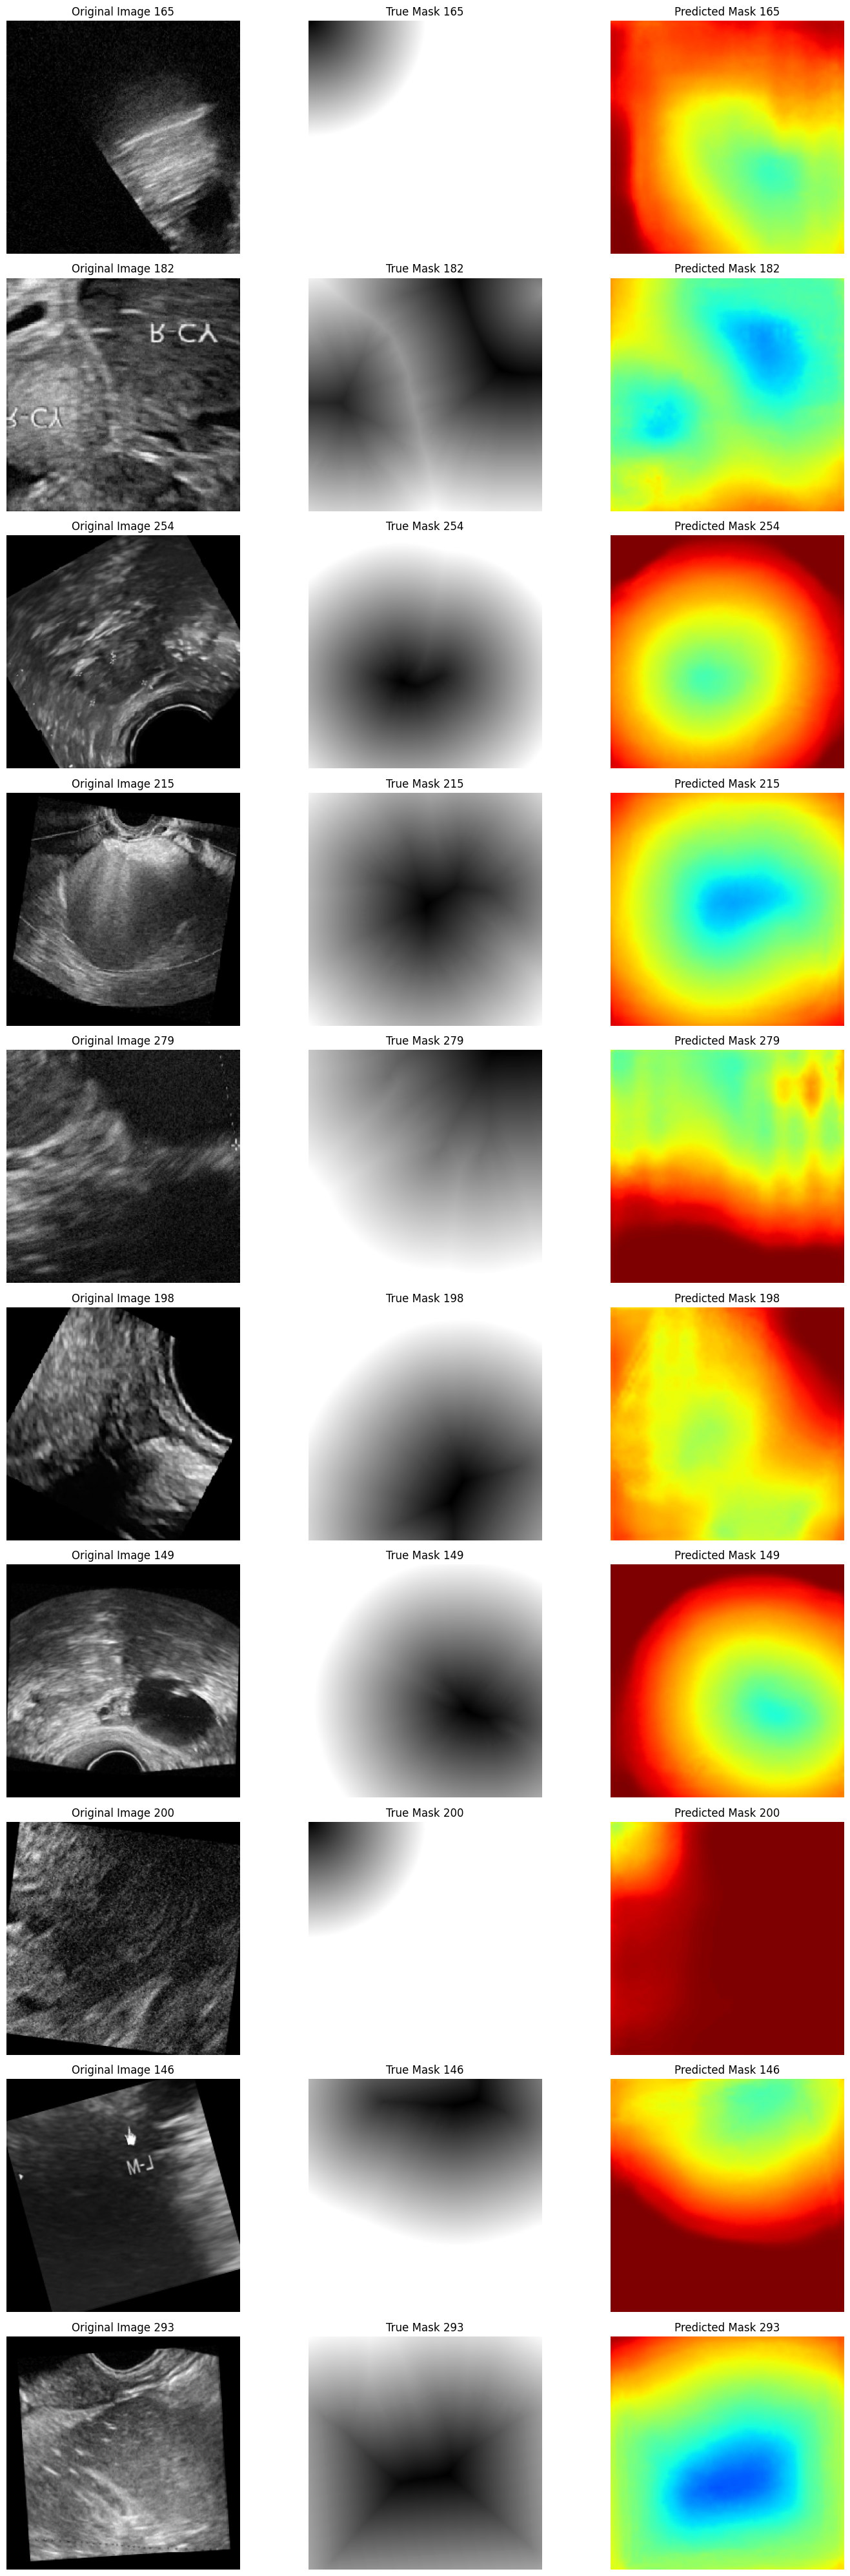

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation dataset
indices = torch.randperm(len(validation_dataset))[:10]

# Create a figure for plotting
fig, axs = plt.subplots(10, 3, figsize=(15, 40))  # 10 rows, 3 columns

with torch.no_grad():
    for i, idx in enumerate(indices):
        # Get the ith sample
        image, true_mask = validation_dataset[idx]

        # Add batch dimension and transfer to the same device as model
        image_batch = image.unsqueeze(0).to(device)

        # Get model prediction
        prediction = model(image_batch)
        #predicted_mask = torch.argmax(prediction, dim=1).squeeze(0).cpu()
        predicted_mask = prediction.squeeze(0).cpu()

        # Convert tensors to numpy arrays for plotting
        image_np = image.squeeze().cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        predicted_mask_np = predicted_mask.numpy()

        # Plot original image
        axs[i, 0].imshow(image_np, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Original Image {idx}')

        # Plot true mask
        axs[i, 1].imshow(true_mask_np, cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f'True Mask {idx}')

        # Plot predicted mask
        axs[i, 2].imshow(predicted_mask_np[0], cmap='jet', vmax = 1, vmin = -1)
        axs[i, 2].axis('off')
        axs[i, 2].set_title(f'Predicted Mask {idx}')

plt.tight_layout()
plt.show()